# Chapter 10

## Building an Image Classifier Using the Sequential API

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

In [2]:
root_dir = 'data'
full_train_dset = FashionMNIST(root=root_dir,
                               train=True,
                               download=True,
                               transform=ToTensor())
test_dset = FashionMNIST(root=root_dir,
                         train=False,
                         download=True,
                         transform=ToTensor())

In [3]:
device = 'cuda'
if torch.cuda.device_count() == 2:
    torch.cuda.set_device(1)

In [4]:
train_dset = Subset(full_train_dset, indices=range(55000))
valid_dset = Subset(full_train_dset, indices=range(55000, 60000))

In [5]:
len(train_dset), len(valid_dset)

(55000, 5000)

In [6]:
batch_size = 32 # Default batch size on keras

In [7]:
train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

## Normalization

In Geron's book the data are normalized by dividing by 255. The `ToTensor()` transform added to the Dataset definition takes care of this automatically.

In [8]:
img, tgt = next(iter(valid_loader))

In [9]:
img.max()

tensor(1.)

In [10]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [11]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential_model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=784, out_features=300),
            nn.ReLU(),
            nn.Linear(in_features=300, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=10))
    
    def forward(self, x):
        return self.sequential_model(x)

In [12]:
classif_model = MyModel()
classif_model

MyModel(
  (sequential_model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=300, bias=True)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [13]:
classif_model.sequential_model[1].bias[0]

tensor(0.0025, grad_fn=<SelectBackward0>)

In [14]:
classif_model.sequential_model[1].weight[0, :10]

tensor([-0.0172, -0.0012,  0.0147, -0.0222,  0.0215, -0.0214,  0.0159,  0.0212,
         0.0188, -0.0332], grad_fn=<SliceBackward0>)

## Weight initialization

In Keras weights in a dense layer are, [by default](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), initialized with a Glorot Uniform initialization.

In Pytorch weights in a linear layer are, [by default](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) initialized with a uniform distribution with  U(−k,k) where k=1/in_features. This is essentially a LeCun uniform initialization. Note that in PyTorch, Glorot initialization is called Xavier initialization.

In [15]:
@torch.no_grad()
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.)

In [16]:
classif_model.apply(init_weights)

MyModel(
  (sequential_model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=300, bias=True)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [17]:
classif_model.sequential_model[1].bias[0]

tensor(0., grad_fn=<SelectBackward0>)

In [18]:
classif_model.sequential_model[1].weight[0, :10]

tensor([-0.0434,  0.0522,  0.0365, -0.0370, -0.0265,  0.0726,  0.0289,  0.0270,
        -0.0580, -0.0119], grad_fn=<SliceBackward0>)

Both the bias and the weight look different. We assume that we are using the same initialization approach as Keras.

The Keras model has a final softmax activation. If we use PyTorch cross-entropy loss, the softmax is fused in the loss, so we don't need to include it.

In [19]:
classif_model.to(device)

MyModel(
  (sequential_model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=300, bias=True)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [20]:
loss_fn = torch.nn.CrossEntropyLoss()

## Optimizers

The example in Geron's book uses the "sgd" optimizer, which I suspect corresponds to the [default settings](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/SGD), i.e., lr = 0.01 and momentum = 0.0.

In [21]:
classif_optim = optim.SGD(classif_model.parameters(), lr=0.01, momentum=0.0)

In [22]:
def train(dataloader, model, loss_fn, optimizer):
    num_obs = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        preds = model(x)
        batch_loss = loss_fn(preds, y)
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 250 == 0:
            print(f'Train loss: {batch_loss.item():>.5}')

In [23]:
def validate(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    num_obs = len(dataloader.dataset)
    total_loss = 0
    correct = 0
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            total_loss += loss_fn(preds, y).item()
            correct += (preds.argmax(1) == y).type(torch.float).sum().item()
    avg_batch_loss = total_loss / num_batches
    accuracy = correct / num_obs
    print('Validation:')
    print(f'\nAverage loss: {avg_batch_loss:>.5} - Accuracy: {accuracy:>.3}')
    return avg_batch_loss, accuracy

In [24]:
epochs = 30

In [25]:
test_loss, test_accuracy = [], []

for epoch in range(epochs):
    print(f'\n----- Epoch: {epoch+1} -----\n')
    train(train_loader, classif_model, loss_fn, classif_optim)
    loss, acc = validate(valid_loader, classif_model, loss_fn)
    test_loss.append(loss)
    test_accuracy.append(acc)


----- Epoch: 1 -----

Train loss: 2.3564
Train loss: 0.78182
Train loss: 0.7641
Train loss: 0.66306
Train loss: 0.78993
Train loss: 0.5127
Train loss: 0.42563
Validation:

Average loss: 0.50528 - Accuracy: 0.823

----- Epoch: 2 -----

Train loss: 0.48282
Train loss: 0.31914
Train loss: 0.50171
Train loss: 0.59217
Train loss: 0.23079
Train loss: 0.69483
Train loss: 0.3701
Validation:

Average loss: 0.47227 - Accuracy: 0.835

----- Epoch: 3 -----

Train loss: 0.2188
Train loss: 0.4403
Train loss: 0.38261
Train loss: 0.44017
Train loss: 0.89349
Train loss: 0.48471
Train loss: 0.39363
Validation:

Average loss: 0.4271 - Accuracy: 0.848

----- Epoch: 4 -----

Train loss: 0.4441
Train loss: 0.34227
Train loss: 0.29001
Train loss: 0.35759
Train loss: 0.60983
Train loss: 0.68696
Train loss: 0.39053
Validation:

Average loss: 0.40234 - Accuracy: 0.858

----- Epoch: 5 -----

Train loss: 0.67423
Train loss: 0.51525
Train loss: 0.14682
Train loss: 0.31169
Train loss: 0.30618
Train loss: 0.2535
Tr

This is very similar to the performance shown in Geron's book.

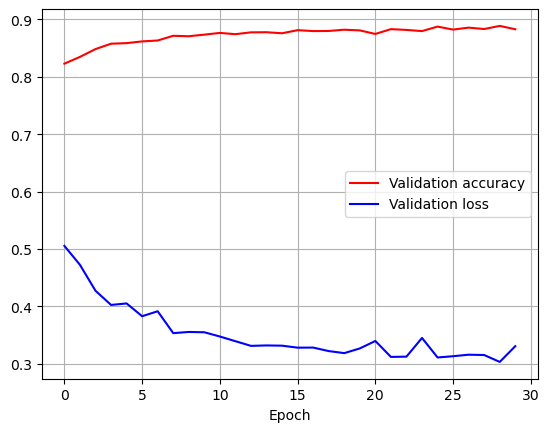

In [26]:
plt.plot(np.arange(30), test_accuracy, 'r-', label='Validation accuracy')
plt.plot(np.arange(30), test_loss, 'b-', label='Validation loss')
plt.grid()
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Performance on the test set

In [27]:
def get_test_performance(dataloader, model):
    test_accuracy = 0
    correct = 0
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            correct += (preds.argmax(1) == y).type(torch.float32).sum().item()
    return correct / len(dataloader.dataset)

In [28]:
get_test_performance(test_loader, classif_model)

0.8731

## Building a Regression MLP Using the Sequential API

For this example we use the California Housing dataset. After creating a training, validation, and test set, we must normalize the data and organize them into dataloaders.

**Note**: in HOML3 the loss is the mean squared error (MSE), but the metric is the root mean squared error (RMSE), therefore to go from the loss to the metric, you have to take the square root of the loss. Our loss and the loss in HOML3 should be directly comparable.

In [29]:
housing = fetch_california_housing()
x_train_full, x_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_full, y_train_full, random_state=42)

In [30]:
x_train.shape, x_valid.shape, x_test.shape

((11610, 8), (3870, 8), (5160, 8))

In [31]:
x_train[0]

array([ 3.52140000e+00,  1.50000000e+01,  3.04994451e+00,  1.10654828e+00,
        1.44700000e+03,  1.60599334e+00,  3.76300000e+01, -1.22430000e+02])

The data is clearly not normalized.

In [32]:
x_train.min(), x_train.max(), x_valid.min(), x_valid.max(), x_test.min(), x_test.max()

(-124.35, 16305.0, -124.27, 35682.0, -124.25, 16122.0)

In [33]:
means, std_devs = x_train.mean(axis=0), x_train.std(axis=0)
means.shape, std_devs.shape

((8,), (8,))

In [34]:
z_train = ((x_train - means) / std_devs).astype(np.float32)
z_valid = ((x_valid - means) / std_devs).astype(np.float32)
z_test = ((x_test - means) / std_devs).astype(np.float32)

In [35]:
z_test.dtype

dtype('float32')

In [36]:
z_train.mean(), z_train.std(), z_valid.mean(), z_valid.std(), z_test.mean(), z_test.std()

(2.4642746e-10, 1.0, 0.021390013, 3.6403675, -0.004968547, 0.99959093)

In [37]:
x_tensor_train = torch.FloatTensor(z_train)
y_tensor_train = torch.FloatTensor(y_train).unsqueeze(-1)
x_tensor_valid = torch.FloatTensor(z_valid)
y_tensor_valid = torch.FloatTensor(y_valid).unsqueeze(-1)
x_tensor_test = torch.FloatTensor(z_test)
y_tensor_test = torch.FloatTensor(y_test).unsqueeze(-1)

In [38]:
x_tensor_valid.mean(), x_tensor_valid.std()

(tensor(0.0214), tensor(3.6404))

In [39]:
train_dset = TensorDataset(x_tensor_train, y_tensor_train)
valid_dset = TensorDataset(x_tensor_valid, y_tensor_valid)
test_dset = TensorDataset(x_tensor_test, y_tensor_test)

In [40]:
train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

In [41]:
class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential_model = nn.Sequential(
            nn.Linear(in_features=8, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=1))
    
    def forward(self, x):
        return self.sequential_model(x)

### Weight initialization

In [42]:
regression_model = RegressionModel()
regression_model.apply(init_weights)

RegressionModel(
  (sequential_model): Sequential(
    (0): Linear(in_features=8, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [43]:
regression_model = regression_model.to(device)

In [44]:
def train_regression(dataloader, model, loss_fn, optimizer):
    total_loss = 0
    num_obs = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        preds = model(x)
        batch_loss = loss_fn(preds, y)
        total_loss += batch_loss.item()
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Train Loss: {total_loss/num_batches:>.5}")

In [45]:
def eval_regression(dataloader, model, loss_fn):
    total_loss = 0
    num_obs = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            total_loss += loss_fn(preds, y).item()
        print(f'Validation Loss: {total_loss/num_batches:>.5}')

In [46]:
loss_fn = nn.MSELoss()
regression_optim = optim.Adam(regression_model.parameters(), lr=1e-3, eps=1e-7)

In [47]:
for epoch in range(20):
    print(f'\n ----- Epoch {epoch+1} -----')
    train_regression(train_loader, regression_model, loss_fn, regression_optim)
    eval_regression(valid_loader, regression_model, loss_fn)


 ----- Epoch 1 -----
Train Loss: 0.82841
Validation Loss: 0.55169

 ----- Epoch 2 -----
Train Loss: 0.37154
Validation Loss: 2.2622

 ----- Epoch 3 -----
Train Loss: 0.36366
Validation Loss: 0.32544

 ----- Epoch 4 -----
Train Loss: 0.33822
Validation Loss: 0.64965

 ----- Epoch 5 -----
Train Loss: 0.32801
Validation Loss: 1.4544

 ----- Epoch 6 -----
Train Loss: 0.32435
Validation Loss: 1.4592

 ----- Epoch 7 -----
Train Loss: 0.31361
Validation Loss: 3.8273

 ----- Epoch 8 -----
Train Loss: 0.34039
Validation Loss: 0.36349

 ----- Epoch 9 -----
Train Loss: 0.30402
Validation Loss: 0.56003

 ----- Epoch 10 -----
Train Loss: 0.30735
Validation Loss: 1.3594

 ----- Epoch 11 -----
Train Loss: 0.31131
Validation Loss: 0.37016

 ----- Epoch 12 -----
Train Loss: 0.29403
Validation Loss: 1.0019

 ----- Epoch 13 -----
Train Loss: 0.30035
Validation Loss: 0.53096

 ----- Epoch 14 -----
Train Loss: 0.29183
Validation Loss: 0.40373

 ----- Epoch 15 -----
Train Loss: 0.28541
Validation Loss: 0.2

## Building Complex Models Using the Functional API

In [48]:
class WideAndDeep(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer1 = nn.Linear(in_features=8, out_features=30)
        self.relu = nn.ReLU()
        self.hidden_layer2 = nn.Linear(in_features=30, out_features=30)
        self.output_layer = nn.Linear(in_features=38, out_features=1)
    
    def forward(self, x):
        z = self.relu(self.hidden_layer1(x))
        z = self.relu(self.hidden_layer2(z))
        w = torch.cat((x, z), dim=-1)
        return self.output_layer(w)

In [49]:
widedeep = WideAndDeep()
widedeep.apply(init_weights)
widedeep = widedeep.to(device)

Note that we need to create another optimizer, as the existing one has been trained on a different architecture.

In [50]:
wnd_optim = optim.Adam(widedeep.parameters(), lr=1e-3, eps=1e-7)

In [51]:
for epoch in range(20):
    print(f'\n ----- Epoch {epoch+1} -----')
    train_regression(train_loader, widedeep, loss_fn, wnd_optim)
    eval_regression(valid_loader, widedeep, loss_fn)


 ----- Epoch 1 -----
Train Loss: 1.3558
Validation Loss: 3.3985

 ----- Epoch 2 -----
Train Loss: 0.46591
Validation Loss: 0.57788

 ----- Epoch 3 -----
Train Loss: 0.39137
Validation Loss: 0.35826

 ----- Epoch 4 -----
Train Loss: 0.37376
Validation Loss: 0.34647

 ----- Epoch 5 -----
Train Loss: 0.36318
Validation Loss: 0.41629

 ----- Epoch 6 -----
Train Loss: 0.35329
Validation Loss: 1.2227

 ----- Epoch 7 -----
Train Loss: 0.34655
Validation Loss: 1.9933

 ----- Epoch 8 -----
Train Loss: 0.36074
Validation Loss: 1.7717

 ----- Epoch 9 -----
Train Loss: 0.35534
Validation Loss: 3.4004

 ----- Epoch 10 -----
Train Loss: 0.3561
Validation Loss: 1.7216

 ----- Epoch 11 -----
Train Loss: 0.33839
Validation Loss: 1.4947

 ----- Epoch 12 -----
Train Loss: 0.32793
Validation Loss: 0.4553

 ----- Epoch 13 -----
Train Loss: 0.32642
Validation Loss: 1.1004

 ----- Epoch 14 -----
Train Loss: 0.32041
Validation Loss: 0.85418

 ----- Epoch 15 -----
Train Loss: 0.31686
Validation Loss: 1.6981



### Sending inputs through two different paths

The next example HOML3 sends features 0 to 4 to the wide path and features 2 to 7 through the deep path as shown below:

![wide_deep](img/mls3_1015.png)

To make this work we need to:

1. Modify the Dataset so that it returns two inputs and one target.
2. Modify the model so that it has two inputs.

In this case, since there is only one output, the loss is unchanged. The source code for TensorDataset can be found [here](https://github.com/pytorch/pytorch/blob/03de15806e5d27ee4ef6d82dbcc66dac78f6e3bf/torch/utils/data/dataset.py#L193).

We just need to redefine `__getitem__()` and we don't need to touch `__init__()`. Our modified implementation returns a tuple containing a tuple of inputs and the output tensor.

In [52]:
class WideAndDeepDataset(TensorDataset):
    def __getitem__(self, index):
        x, y = self.tensors
        return (x[index, :5], x[index, 2:], y[index])

In [53]:
wnd_train_dset = WideAndDeepDataset(x_tensor_train, y_tensor_train)
wnd_valid_dset = WideAndDeepDataset(x_tensor_valid, y_tensor_valid)
wnd_test_dset = WideAndDeepDataset(x_tensor_test, y_tensor_test)

In [54]:
wnd_train_loader = DataLoader(wnd_train_dset, batch_size, shuffle=True)
wnd_valid_loader = DataLoader(wnd_valid_dset, batch_size, shuffle=False)
wnd_test_loader = DataLoader(wnd_test_dset, batch_size, shuffle=False)

In [55]:
class WideAndDeepTwoInputs(nn.Module):
    # x_wide contains 5 features. x_deep contains 6
    def __init__(self):
        super().__init__()
        self.hidden_layer1 = nn.Linear(in_features=6, out_features=30)
        self.relu = nn.ReLU()
        self.hidden_layer2 = nn.Linear(in_features=30, out_features=30)
        self.output_layer = nn.Linear(in_features=35, out_features=1)
    
    def forward(self, x_wide, x_deep):
        x_deep = self.relu(self.hidden_layer1(x_deep))
        x_deep = self.relu(self.hidden_layer2(x_deep))
        w = torch.cat((x_wide, x_deep), dim=-1)
        return self.output_layer(w)

In [56]:
model_two_inputs = WideAndDeepTwoInputs()
model_two_inputs.apply(init_weights)
model_two_inputs = model_two_inputs.to(device)

In [57]:
def train_two_inputs(dataloader, model, loss_fn, optimizer):
    total_loss = 0
    num_obs = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    for batch, (x_wide, x_deep, y) in enumerate(dataloader):
        x_wide, x_deep, y = x_wide.to(device), x_deep.to(device), y.to(device)
        preds = model(x_wide, x_deep)
        batch_loss = loss_fn(preds, y)
        total_loss += batch_loss.item()
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Train Loss: {total_loss/num_batches:>.5}")

In [58]:
def eval_two_inputs(dataloader, model, loss_fn):
    total_loss = 0
    num_obs = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    with torch.no_grad():
        for x_wide, x_deep, y in dataloader:
            x_wide, x_deep, y = x_wide.to(device), x_deep.to(device), y.to(device)
            preds = model(x_wide, x_deep)
            total_loss += loss_fn(preds, y).item()
        print(f'Validation Loss: {total_loss/num_batches:>.5}')

In [59]:
wnd_optim_two_inputs = optim.Adam(model_two_inputs.parameters(), lr=1e-3, eps=1e-7)

In [60]:
for epoch in range(20):
    print(f"\n----- Epoch: {epoch+1} -----")
    train_two_inputs(wnd_train_loader, model_two_inputs, loss_fn, wnd_optim_two_inputs)
    eval_two_inputs(wnd_valid_loader, model_two_inputs, loss_fn)


----- Epoch: 1 -----
Train Loss: 1.3503
Validation Loss: 1.2598

----- Epoch: 2 -----
Train Loss: 0.6067
Validation Loss: 0.53724

----- Epoch: 3 -----
Train Loss: 0.48713
Validation Loss: 0.44046

----- Epoch: 4 -----
Train Loss: 0.42955
Validation Loss: 0.46473

----- Epoch: 5 -----
Train Loss: 0.39422
Validation Loss: 0.65582

----- Epoch: 6 -----
Train Loss: 0.37524
Validation Loss: 1.7768

----- Epoch: 7 -----
Train Loss: 0.37171
Validation Loss: 1.0006

----- Epoch: 8 -----
Train Loss: 0.36554
Validation Loss: 1.4627

----- Epoch: 9 -----
Train Loss: 0.35748
Validation Loss: 1.1696

----- Epoch: 10 -----
Train Loss: 0.3555
Validation Loss: 0.35428

----- Epoch: 11 -----
Train Loss: 0.3474
Validation Loss: 0.49802

----- Epoch: 12 -----
Train Loss: 0.34205
Validation Loss: 1.0847

----- Epoch: 13 -----
Train Loss: 0.34541
Validation Loss: 1.3652

----- Epoch: 14 -----
Train Loss: 0.34595
Validation Loss: 0.65656

----- Epoch: 15 -----
Train Loss: 0.33612
Validation Loss: 0.3335



### Multiple inputs and multiple outputs

![multiple_outputs](img/multioutput.png)

The model now returns two outputs which go into two separate losses that are then added together.

In [61]:
class MulitpleOutputsModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer1 = nn.Linear(in_features=6, out_features=30)
        self.relu = nn.ReLU()
        self.hidden_layer2 = nn.Linear(in_features=30, out_features=30)
        self.output_layer = nn.Linear(in_features=35, out_features=1)
        self.aux_output = nn.Linear(in_features=30, out_features=1)
    
    def forward(self, x_wide, x_deep):
        x_deep = self.relu(self.hidden_layer1(x_deep))
        x_deep = self.relu(self.hidden_layer2(x_deep))
        main_out = self.output_layer(torch.cat((x_wide, x_deep), dim=-1))
        aux_out = self.aux_output(x_deep)
        return main_out, aux_out

In [62]:
multi_output_model = MulitpleOutputsModel()
multi_output_model.apply(init_weights)
multi_output_model = multi_output_model.to(device)

In [63]:
multi_output_optim = optim.Adam(multi_output_model.parameters(), eps=1e-7)

In [64]:
def train_two_outputs(dataloader, model, loss_fn, optimizer, weights):
    total_loss = 0
    num_obs = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    for batch, (x_wide, x_deep, y) in enumerate(dataloader):
        x_wide, x_deep, y = x_wide.to(device), x_deep.to(device), y.to(device)
        main_preds, aux_preds = model(x_wide, x_deep)
        main_loss, aux_loss = loss_fn(main_preds, y), loss_fn(aux_preds, y)
        batch_loss = weights[0]*main_loss + weights[1]*aux_loss
        total_loss += batch_loss.item()
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Train Loss: {total_loss/num_batches:>.5}")

In [65]:
def eval_two_outputs(dataloader, model, loss_fn, weights):
    total_loss = 0
    num_obs = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    with torch.no_grad():
        for x_wide, x_deep, y in dataloader:
            x_wide, x_deep, y = x_wide.to(device), x_deep.to(device), y.to(device)
            main_preds, aux_preds = model(x_wide, x_deep)
            main_loss, aux_loss = loss_fn(main_preds, y), loss_fn(aux_preds, y)
            batch_loss = weights[0]*main_loss + weights[1]*aux_loss
            total_loss += batch_loss.item()
        print(f'Validation Loss: {total_loss/num_batches:>.5}')

In [66]:
weights = (0.9, 0.1)
for epoch in range(20):
    print(f"\n----- Epoch: {epoch+1} -----")
    train_two_outputs(wnd_train_loader, multi_output_model, loss_fn, multi_output_optim, weights)
    eval_two_outputs(wnd_valid_loader, multi_output_model, loss_fn, weights)


----- Epoch: 1 -----
Train Loss: 1.8976
Validation Loss: 5.2368

----- Epoch: 2 -----
Train Loss: 0.62028
Validation Loss: 1.2181

----- Epoch: 3 -----
Train Loss: 0.46419
Validation Loss: 0.68071

----- Epoch: 4 -----
Train Loss: 0.42583
Validation Loss: 0.46964

----- Epoch: 5 -----
Train Loss: 0.40741
Validation Loss: 0.4235

----- Epoch: 6 -----
Train Loss: 0.39361
Validation Loss: 0.39545

----- Epoch: 7 -----
Train Loss: 0.38376
Validation Loss: 0.38734

----- Epoch: 8 -----
Train Loss: 0.37563
Validation Loss: 0.39303

----- Epoch: 9 -----
Train Loss: 0.36961
Validation Loss: 0.36241

----- Epoch: 10 -----
Train Loss: 0.36345
Validation Loss: 0.42451

----- Epoch: 11 -----
Train Loss: 0.35774
Validation Loss: 0.37336

----- Epoch: 12 -----
Train Loss: 0.35484
Validation Loss: 0.48186

----- Epoch: 13 -----
Train Loss: 0.35043
Validation Loss: 0.48709

----- Epoch: 14 -----
Train Loss: 0.34607
Validation Loss: 0.93839

----- Epoch: 15 -----
Train Loss: 0.34417
Validation Loss: 0